In [1]:
import ttslearn
ttslearn.__version__

'0.2.2'

In [2]:
from ttslearn.dnntts import DNNTTS
from IPython.display import Audio

engine = DNNTTS()
wav, sr = engine.tts("日本語合成音声のデモです。")
Audio(wav, rate=sr)


In [3]:
from scipy.io import wavfile
import ttslearn

sr,wav=wavfile.read(ttslearn.util.example_audio_file())

In [4]:
sr

48000

In [5]:
wav.shape

(153120,)

In [6]:
len(wav)/sr

3.19

In [7]:
wav

array([  74,   47,   17, ..., -144, -143, -144], dtype=int16)

In [8]:
type(wav)

numpy.ndarray

In [9]:
Audio(wav, rate=sr)


Text(29.222222222222214, 0.5, 'Amplitude')

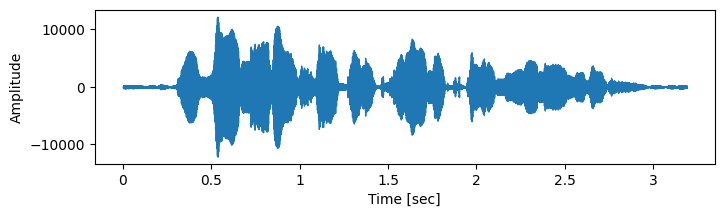

In [10]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 2))
librosa.display.waveshow(wav.astype(np.float32), sr=sr, ax=ax)

ax.set_xlabel("Time [sec]")
ax.set_ylabel("Amplitude")

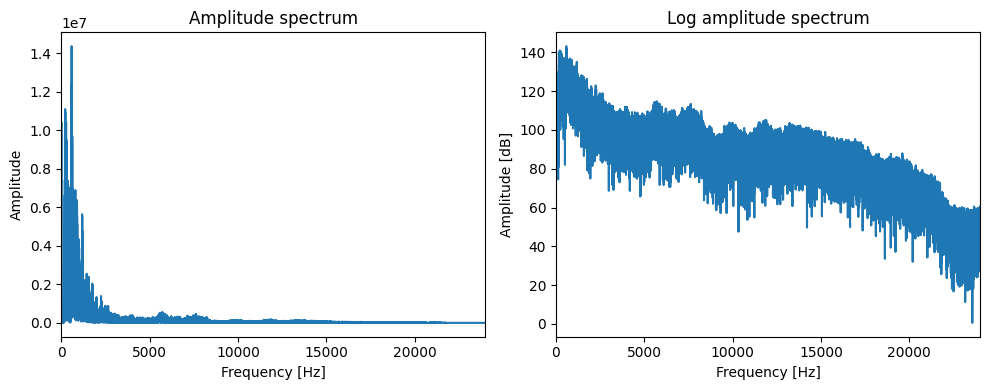

In [11]:
# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())
# 振幅スペクトル
X = np.abs(np.fft.rfft(x))
# 対数振幅スペクトル
logX = 20*np.log10(X)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
freq = np.arange(len(X)) / 2 / len(X) * sr
ax[0].plot(freq, X)
ax[0].set_title("Amplitude spectrum")
ax[0].set_xlim(0, sr // 2)
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Amplitude")

ax[1].plot(freq, logX)
ax[1].set_title("Log amplitude spectrum")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Amplitude [dB]")
plt.tight_layout()

In [17]:
def hanning(N):
    n = np.arange(N)
    w = 0.5 - 0.5 * np.cos(2 * np.pi * n / N)
    return w


def stft(x, N, S):
    # 窓関数（簡単のため、窓幅とフレーム長 N は同じとします）
    w = hanning(N)
    # 短時間フーリエ変換のフレーム数
    M = (len(x) - N) // S + 1
    # 短時間フーリエ変換の結果格納用の 2 次元配列
    X = np.zeros((M, N // 2 + 1), dtype=complex)
    # 音声をずらして切り出し、フーリエ変換
    for m in range(M):
        x_m = w * x[m * S : m * S + N]
        X[m, :] = np.fft.rfft(x_m)
    return X


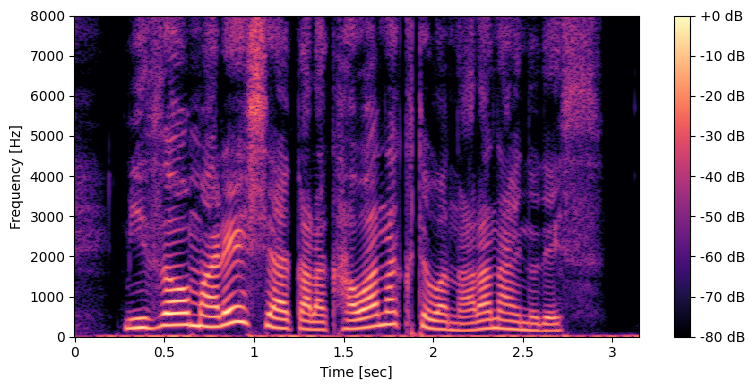

In [19]:
# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())

# 5 ミリ秒のフレームシフトを考えます
frame_shift = int(sr * 0.005)
n_fft = 2048
# スペクトログラム
X = stft(x.astype(np.float32), n_fft, frame_shift)
# 対数振幅に変換
logX = librosa.amplitude_to_db(np.abs(X), ref=np.max)

fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
img = librosa.display.specshow(
    # logXは[時間,周波数]なので転置している?
    logX.T, hop_length=frame_shift, sr=sr, x_axis="time", y_axis="hz", ax=ax
)
fig.colorbar(img, ax=ax, format="%+2.f dB")
# 音声のパワーは低域に集中するため、8000 Hz までを表示する
ax.set_ylim(0, 8000)

ax.set_xlabel("Time [sec]")
ax.set_ylabel("Frequency [Hz]")
plt.tight_layout()


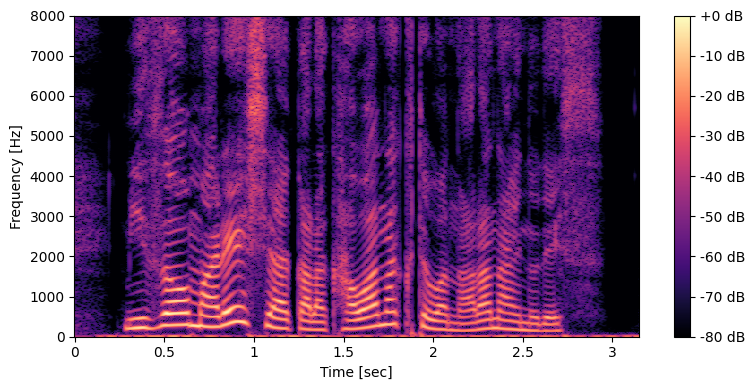

In [21]:
X = librosa.stft(
    x.astype(np.float32),
    n_fft=n_fft,
    win_length=n_fft,
    hop_length=frame_shift,
    window="hann",
    center=False,
).T
logX = librosa.amplitude_to_db(np.abs(X), ref=np.max)

fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
img = librosa.display.specshow(
    # logXは[時間,周波数]なので転置している?
    logX.T,
    hop_length=frame_shift,
    sr=sr,
    x_axis="time",
    y_axis="hz",
    ax=ax,
)
fig.colorbar(img, ax=ax, format="%+2.f dB")
# 音声のパワーは低域に集中するため、8000 Hz までを表示する
ax.set_ylim(0, 8000)

ax.set_xlabel("Time [sec]")
ax.set_ylabel("Frequency [Hz]")
plt.tight_layout()


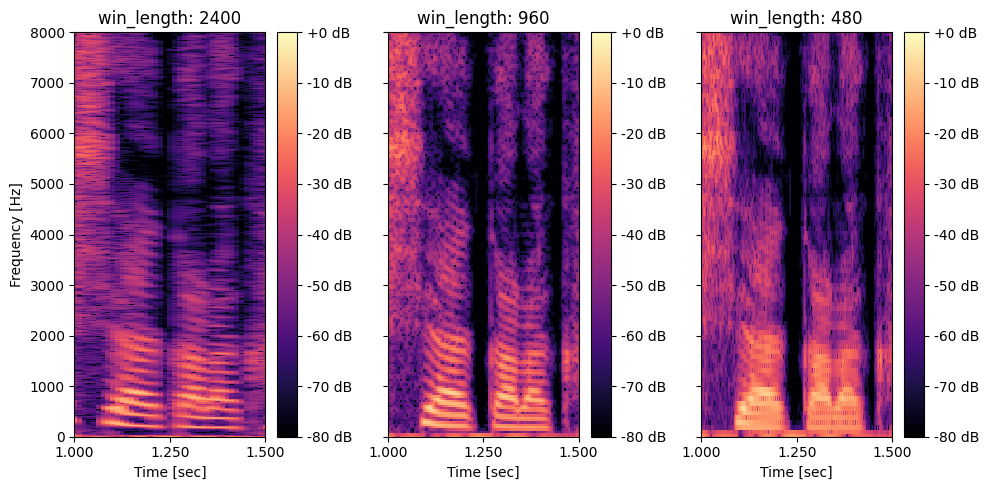

In [24]:
def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

for idx, win_length_ms in enumerate([0.05, 0.02, 0.01]):
    win_length = int(sr * win_length_ms)
    frame_shift = win_length // 4
    n_fft = next_power_of_2(win_length)

    X = librosa.stft(
        x.astype(np.float32), n_fft=n_fft, win_length=n_fft, hop_length=frame_shift
    ).T
    logX = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    mesh = librosa.display.specshow(
        logX.T, hop_length=frame_shift, sr=sr, x_axis="time", y_axis="hz", ax=ax[idx]
    )
    fig.colorbar(mesh, ax=ax[idx], format="%+2.f dB")
    ax[idx].set_title(f"win_length: {win_length}")
    mesh.set_clim(-80, 0)
    ax[idx].set_xlim(1.0, 1.5)
    ax[idx].set_xticks([1.0, 1.25, 1.5])
    # あとでラベルを付け直すので、ここでは消しておく
    ax[idx].set_ylabel("")

ax[0].set_ylabel("Frequency [Hz]")
for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylim(0, 8000)
    # a.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
plt.tight_layout()


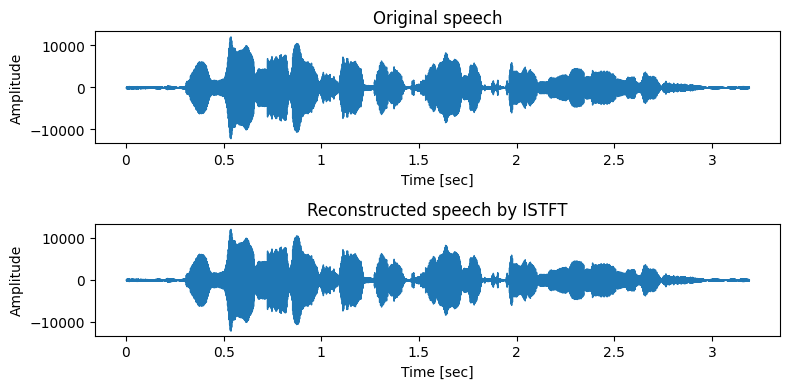

In [27]:
import IPython

# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())
# 5 ミリ秒のフレームシフトを考えます
frame_shift = int(sr * 0.005)
n_fft = 2048

# STFT
X = librosa.stft(
    x.astype(np.float32),
    n_fft=n_fft,
    win_length=n_fft,
    hop_length=frame_shift,
    window="hann",
)
# ISTFT
x_hat = librosa.istft(X, win_length=n_fft, hop_length=frame_shift, window="hann")

IPython.display.display(Audio(x.astype(np.float32), rate=sr))
IPython.display.display(Audio(x_hat.astype(np.float32), rate=sr))

fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharey=True)
ax[0].set_title("Original speech")
ax[1].set_title("Reconstructed speech by ISTFT")
librosa.display.waveshow(x.astype(np.float32), sr=sr, ax=ax[0])
librosa.display.waveshow(x_hat.astype(np.float32), sr=sr, ax=ax[1])

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Amplitude")
plt.tight_layout()


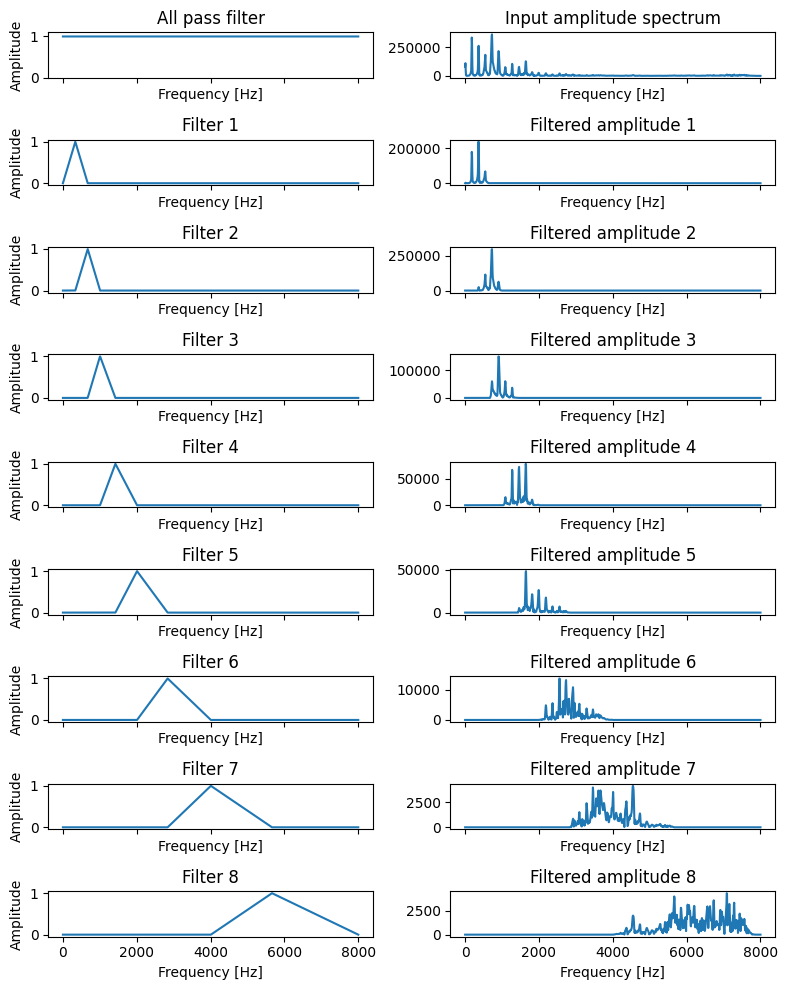

In [30]:
sr = 16000
n_fft = 2048
n_mels = 8

# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())
x = x.astype(np.float32)
x = librosa.resample(x, orig_sr=sr, target_sr=16000)
sr = 16000

# 5 ミリ秒のフレームシフトを考えます
frame_shift = int(sr * 0.005)
# STFT
X = librosa.stft(
    x, n_fft=n_fft, win_length=n_fft, hop_length=frame_shift, window="hann"
)
# 1 フレームを切り出す
X_m = np.abs(X[:, 280])

# メルフィルタバンク: n_mels 個のフィルタから構成されます
melfb = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, norm=None)
freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

# メルフィルタバンクを表示
fig, ax = plt.subplots(n_mels + 1, 2, figsize=(8, 10), sharex=True)
ax[0][0].plot(freq, np.ones_like(freq))
ax[0][0].set_title("All pass filter")
ax[0][0].set_ylim(0, 1.1)
ax[0][1].plot(freq, X_m)
ax[0][1].set_title("Input amplitude spectrum")
for idx, fb in enumerate(melfb):
    ax[idx + 1][0].plot(freq, fb)
    ax[idx + 1][0].set_title(f"Filter {idx+1}")
    ax[idx + 1][1].plot(freq, fb * X_m)
    ax[idx + 1][1].set_title(f"Filtered amplitude {idx+1}")

for a, b in ax:
    a.set_xlabel("Frequency [Hz]")
    b.set_xlabel("Frequency [Hz]")
    a.set_ylabel("Amplitude")
plt.tight_layout()


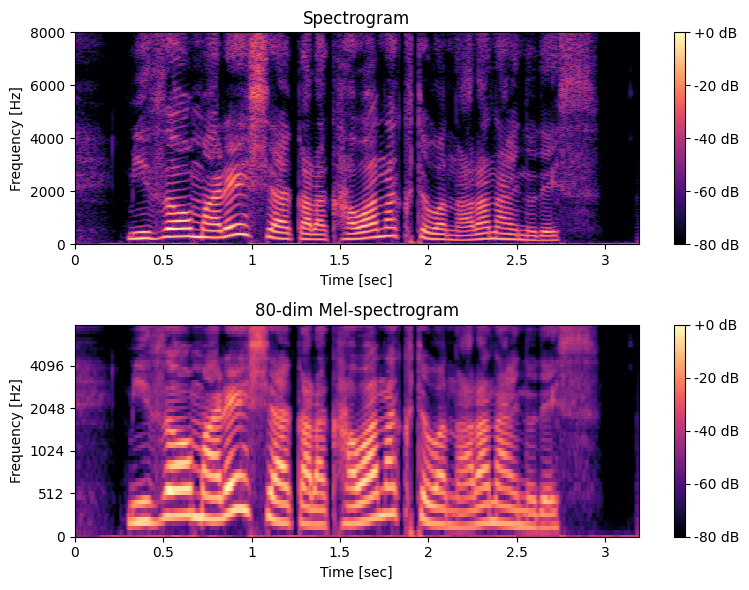

In [32]:
# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())
# 5 ミリ秒のフレームシフトを考えます
frame_shift = int(sr * 0.005)
n_fft = 2048

# スペクトログラム
X = librosa.stft(x.astype(np.float32), n_fft=n_fft, hop_length=frame_shift)

# 80 次元のメルスペクトログラム
n_mels = 80
melfb = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
melspec = librosa.amplitude_to_db(np.dot(melfb, np.abs(X)), ref=np.max)

# 比較用の対数振幅スペクトログラム
logX = librosa.amplitude_to_db(np.abs(X), ref=np.max)

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].set_title("Spectrogram")
ax[1].set_title("80-dim Mel-spectrogram")
mesh = librosa.display.specshow(
    logX, hop_length=frame_shift, sr=sr, x_axis="time", y_axis="hz", ax=ax[0]
)
fig.colorbar(mesh, ax=ax[0], format="%+2.f dB")
mesh.set_clim(-80, 0)
mesh = librosa.display.specshow(
    melspec,
    hop_length=frame_shift,
    sr=sr,
    x_axis="time",
    y_axis="mel",
    ax=ax[1],
)
fig.colorbar(mesh, ax=ax[1], format="%+2.f dB")
mesh.set_clim(-80, 0)

for a in ax:
    a.set_ylim(0, 8000)
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Frequency [Hz]")
plt.tight_layout()


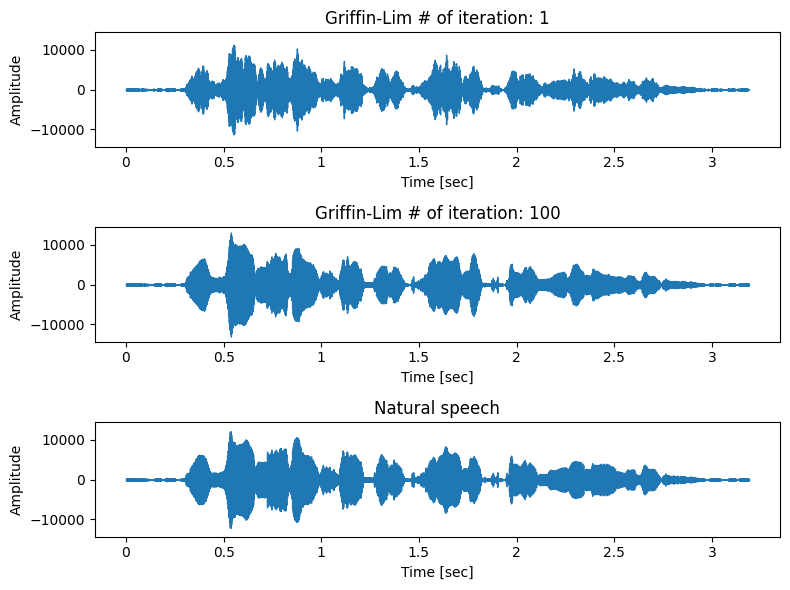

In [33]:
# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())
# 5 ミリ秒のフレームシフトを考えます
frame_shift = int(sr * 0.005)
n_fft = 2048

# 振幅スペクトログラム
X = np.abs(librosa.stft(x.astype(np.float32), n_fft=n_fft, hop_length=frame_shift))

y1 = librosa.griffinlim(X, hop_length=frame_shift, n_iter=1)
y2 = librosa.griffinlim(X, hop_length=frame_shift, n_iter=100)

# オーディオプレイヤーの表示
IPython.display.display(Audio(y1, rate=sr))
IPython.display.display(Audio(y2, rate=sr))
IPython.display.display(Audio(x, rate=sr))

fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharey=True)
ax[0].set_title("Griffin-Lim # of iteration: 1")
ax[1].set_title("Griffin-Lim # of iteration: 100")
ax[2].set_title("Natural speech")
librosa.display.waveshow(y1, sr=sr, ax=ax[0])
librosa.display.waveshow(y2, sr=sr, ax=ax[1])
librosa.display.waveshow(x.astype(np.float32), sr=sr, ax=ax[2])

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Amplitude")
plt.tight_layout()


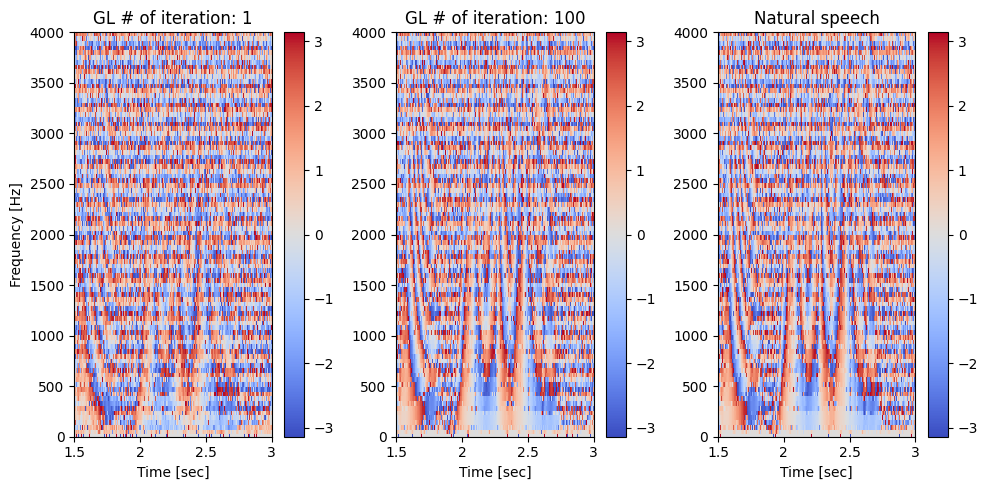

In [35]:
n_fft = 1024
hop_length = n_fft // 4
fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True)

C = librosa.stft(y1, n_fft=n_fft, hop_length=hop_length)
ifreq = np.angle(C[:, 1:] * np.conjugate(C[:, :-1]))
mesh = librosa.display.specshow(
    ifreq, ax=ax[0], x_axis="time", y_axis="hz", sr=sr, hop_length=hop_length
)
fig.colorbar(mesh, ax=ax[0])
ax[0].set_title("GL # of iteration: 1")

C = librosa.stft(y2, n_fft=n_fft, hop_length=hop_length)
ifreq = np.angle(C[:, 1:] * np.conjugate(C[:, :-1]))
mesh = librosa.display.specshow(
    ifreq, ax=ax[1], x_axis="time", y_axis="hz", sr=sr, hop_length=hop_length
)
fig.colorbar(mesh, ax=ax[1])
ax[1].set_title("GL # of iteration: 100")

C = librosa.stft(x.astype(np.float32), n_fft=n_fft, hop_length=hop_length)
ifreq = np.angle(C[:, 1:] * np.conjugate(C[:, :-1]))
mesh = librosa.display.specshow(
    ifreq, ax=ax[2], x_axis="time", y_axis="hz", sr=sr, hop_length=hop_length
)
fig.colorbar(mesh, ax=ax[2])
ax[2].set_title("Natural speech")

for a in ax:
    # あとでラベルを付け直すので、ここでは消しておく
    a.set_ylabel("")

ax[0].set_ylabel("Frequency [Hz]")
for a in ax:
    a.set_xlim(1.5, 3.0)
    a.set_ylim(0, 4000)
    a.set_xlabel("Time [sec]")
    a.set_xticks([1.5, 2.0, 2.5, 3.0])

plt.tight_layout()
